In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import imutils
import cv2

In [2]:
SEP       = os.path.sep
ROOT_PATH = SEP.join(os.getcwd().split(SEP)[:-2])
DATA_PATH = f'{ROOT_PATH}/Datasets/sample'

In [3]:
class Stitcher:
    
    def __init__(self):
        
        self.iscv4 = imutils.is_cv4(or_better = True)
        
    
    def stitch(self, images, ratio = 0.75, reproj_thr = 4.0, show_matches = False):
        
        (imageB, imageA)    = images
        (kpsA  , featuresA) = self.detect_n_describe(imageA)
        (kpsB  , featuresB) = self.detect_n_describe(imageB)
        
        M = self.match_keypoints(kpsA, kpsB, featuresA, featuresB, ratio, reproj_thr)
        if M is None: return None
    
        (matches, H, status) = M
        shape                = (imageA.shape[1] + imageB.shape[1], imageA.shape[0])
        result               = cv2.warpPerspective(imageA, H, shape)
        result[0: imageB.shape[0], 0: imageB.shape[1]] = imageB
        
        if show_matches:
            vis = self.drawMatches(imageA, imageB, kpsA, kpsB, matches, status)
            return (result, vis)
        
        return result
    
    
    def detect_n_describe(self, image):
        
        if self.iscv4:
            
            descriptor      = cv2.xfeatures2d.SIFT_create()
            (kps, features) = descriptor.detectAndCompute(image, None)
            
        else:
            gray            = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            detector        = cv2.FeatureDetector_create('SIFT')
            kps             = detector.detect(gray)
            
            extractor       = cv2.DescriptorExtractor_create('SIFT')
            (kps, features) = extractor.compute(gray, kps)
            
        kps = np.float32([kp.pt for kp in kps])
        return (kps, features)
    
    def match_keypoints(self, kpsA, kpsB, featuresA, featuresB, ratio, reproj_thr):
        
        matcher     = cv2.BFMatcher()
        raw_matches = matcher.knnMatch(featuresA, featuresB, 2)
        matches     = []
        
        for match in raw_matches:
            
            if len(match) == 2 and match[0].distance < match[1].distance * ratio:
                matches.append((match[0].trainIdx, match[0].queryIdx))
                 
        if len(matches) > 4:
            ptsA = np.float32([kpsA[idx] for (_, idx) in matches])
            ptsB = np.float32([kpsB[idx] for (idx, _) in matches])

            (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reproj_thr)

            return (matches, H, status)

        return None
    
    
    def drawMatches(self, imageA, imageB, kpsA, kpsB, matches, status):
        
        (hA, wA) = imageA.shape[ :2]
        (hB, wB) = imageB.shape[ :2]
        
        vis               = np.zeros((max(hA, hB), wA + wB, 3), dtype = 'uint8')
        vis[0 :hA, 0: wA] = imageA
        vis[0 :hB, wA:  ] = imageB
        
        for ((train_idx, query_idx), s) in zip(matches, status):
            
            if s == 1:
                
                ptA = (int(kpsA[query_idx][0])    , int(kpsA[query_idx][1]))
                ptB = (int(kpsB[train_idx][0]) +wA, int(kpsB[train_idx][1]))
                
                cv2.line(vis, ptA, ptB, (0, 255, 0), 1)
                
        return vis

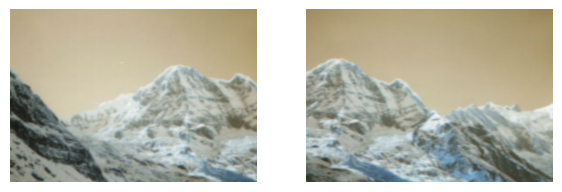

In [4]:
imageA   = cv2.imread( f'{DATA_PATH}/left.png')
imageB   = cv2.imread(f'{DATA_PATH}/right.png')

imageA   = cv2.resize(imageA, (400, 280))
imageB   = cv2.resize(imageB, (400, 280))

_, axes  = plt.subplots(1, 2, figsize = (7, 21))
for image, ax in zip([imageA, imageB], axes):
    
    ax.imshow(image)
    ax.axis(False)

In [5]:
stitcher = Stitcher()
results  = stitcher.stitch([imageA, imageB], show_matches = True) 

[ WARN:0@0.246] global shadow_sift.hpp:13 SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


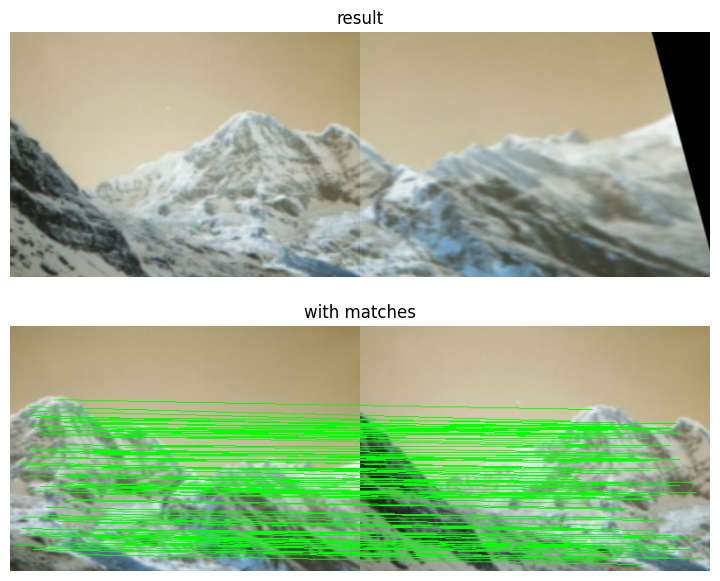

In [6]:
_, axes = plt.subplots(2, 1, figsize = (21, 7))
titles  = ['result', 'with matches']

for (result, ax, title) in zip(results, axes, titles):
    
    ax.imshow(result)
    ax.axis(False)
    ax.set_title(title)